# Baseline Model Comparison

Compare different baseline methods for predicting spatial accuracy patterns.

## Two Evaluation Scenarios

| Scenario | Split Method | Evaluate By | Question Answered |
|----------|--------------|-------------|-------------------|
| **Unseen Spatial** | spatial | grid | How well does the model predict accuracy at new locations? |
| **Unseen Sampling** | sampling | sampling | How well does the model predict accuracy for new density levels? |

## Models Compared

| Category | Model | Description |
|----------|-------|-------------|
| **Traditional ML** | `linear` | Linear Regression |
| | `svm` | Support Vector Regression (RBF) |
| | `lightgbm` | Gradient Boosting |
| **GAM** | `gam_monotonic` | Monotonic GAM with interaction |
| **Interpolation** | `interpolation` | IDW (Inverse Distance Weighting) |
| **Two-Stage** | `two_stage` | GAM (density) + SVM (spatial residual) |


## Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys
from pathlib import Path
%load_ext autoreload
%autoreload 2

# Add geoequity to path
GEOEQUITY_ROOT = Path("..").resolve()
if str(GEOEQUITY_ROOT) not in sys.path:
    sys.path.insert(0, str(GEOEQUITY_ROOT))

# Import geoequity modules
from evaluation import eval_baseline_comparison
from data import calculate_density, split_test_train
from models import SpatialRegressor, InterpolationModel

print("Ready for baseline comparison!")


Ready for baseline comparison!


## 1. Load Data

Load your prediction data with `observed` and `predicted_*` columns.


In [2]:
# Load data - replace with your prediction data
DATA_PATH = 'data/df_example.pkl'
TARGET_COL = 'Ozone'
PRED_COL = 'predicted_linear'

df = pd.read_pickle(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])

# Sample for demo (remove for full analysis)
n_sample = min(200000, len(df))
df = df.sample(n=n_sample, random_state=42).copy()
df['sufficiency'] = len(df)

# Calculate density
df = calculate_density(df, radius=500)

# Train a simple model for demo
from data.feature import simple_feature_engineering
_, _, train_idx, test_idx, df = split_test_train(df, split=0.2, flag='Site', seed=42, verbose=0)

FEATURE_COLS = [c for c in ['TROPOMI_ozone', 'OMI_ozone', 'tco3', 'blh', 't2m', 'latitude', 'longitude'] if c in df.columns]
X, y, _ = simple_feature_engineering(df, FEATURE_COLS, TARGET_COL, standardize=True, verbose=False)

model = LinearRegression()
model.fit(X.loc[train_idx], y.loc[train_idx])
df[PRED_COL] = model.predict(X)
df['observed'] = df[TARGET_COL]

# Use test data
df_analysis = df.loc[test_idx].copy()
print(f"Data: {len(df_analysis):,} samples")
print(f"Density range: [{df_analysis['density'].min():.2e}, {df_analysis['density'].max():.2e}]")


Calculating density (r=500km):   0%|          | 0/1302 [00:00<?, ?it/s]

Data: 39,565 samples
Density range: [4.32e-06, 2.11e-04]


## 2. Run Comparison

The `eval_baseline_comparison` function from `geoequity.evaluation` handles:
- Data splitting (spatial or sampling-based)
- Model training and evaluation
- Results aggregation and display


In [3]:
# Define models to compare
model_list = ['linear', 'lightgbm', 'svm', 'gam_monotonic', 'interpolation', 'two_stage']

print("Models to compare:")
for m in model_list:
    print(f"  - {m}")


Models to compare:
  - linear
  - lightgbm
  - svm
  - gam_monotonic
  - interpolation
  - two_stage


## 3. Scenario 1: Unseen Spatial

**Question**: How well can different methods predict accuracy at new spatial locations?

- Split: By spatial grid (70% train / 30% test grids)
- Evaluate: On held-out spatial grids
- Features: Spatial only (longitude, latitude)


In [5]:
# Scenario 1: Unseen Spatial - predict accuracy at new locations
report_spatial = eval_baseline_comparison(
    df_analysis,
    model_list=model_list,
    density_bins=30,
    split_method='spatial',
    train_by='grid',
    evaluate_by='grid',
    metric='correlation',
    full_features='Spatial'
)



Evaluation: SPATIAL split → GRID evaluate
Features: Spatial | Metric: correlation
Split: Train 30,572 | Test 8,993


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Results (CORRELATION)
Prediction       Linear Regre      LightGBM     SVM (RBF)  Monotonic GA  IDW Interpol  TwoStageMode
---------------------------------------------------------------------------------------------------
linear                -0.1160        0.0739        0.5745        0.4010        0.5903        0.6842


## 4. Scenario 2: Unseen Sampling

**Question**: How well can different methods predict accuracy for new density levels?

- Split: By density bins (70% train / 30% test bins)
- Evaluate: On held-out density bins
- Features: Spatial only (longitude, latitude)


In [7]:
# Scenario 2: Unseen Sampling - predict accuracy at new density levels
report_sampling = eval_baseline_comparison(
    df_analysis,
    model_list=model_list,
    density_bins=30,
    split_method='sampling',
    train_by='grid',
    evaluate_by='sampling',
    metric='correlation',
    full_features='Spatial'
)



Evaluation: SAMPLING split → SAMPLING evaluate
Features: Spatial | Metric: correlation
Split: Train 27,551 | Test 12,014


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Results (CORRELATION)
Prediction       Linear Regre      LightGBM     SVM (RBF)  Monotonic GA  IDW Interpol  TwoStageMode
---------------------------------------------------------------------------------------------------
linear                -0.1404       -0.0121       -0.1961        0.1982        0.1259        0.5168


## 5. Visualize Comparison


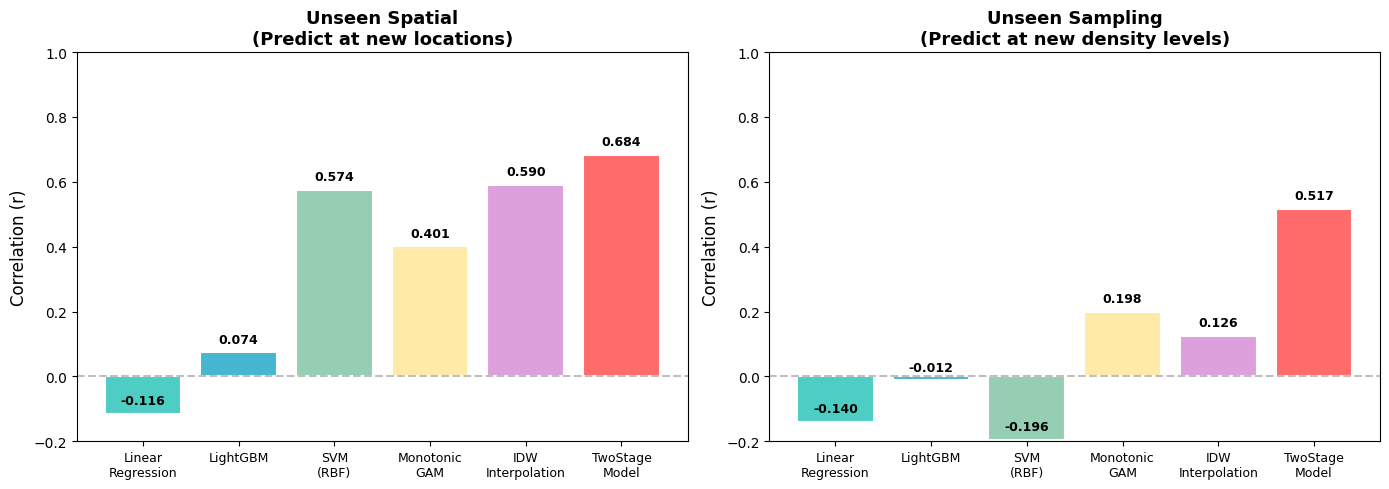

In [8]:
def plot_comparison(report_spatial, report_sampling, model_list):
    """Visualize comparison results."""
    MODEL_DISPLAY = {
        'linear': 'Linear\nRegression',
        'lightgbm': 'LightGBM',
        'svm': 'SVM\n(RBF)',
        'gam_monotonic': 'Monotonic\nGAM',
        'interpolation': 'IDW\nInterpolation',
        'two_stage': 'TwoStage\nModel'
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pred_name = list(report_spatial.keys())[0]
    spatial_scores = [report_spatial[pred_name].get(m, 0) for m in model_list]
    sampling_scores = [report_sampling[pred_name].get(m, 0) for m in model_list]
    
    x = np.arange(len(model_list))
    labels = [MODEL_DISPLAY.get(m, m) for m in model_list]
    colors = ['#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FF6B6B']
    
    # Scenario 1: Unseen Spatial
    bars1 = axes[0].bar(x, spatial_scores, color=colors, edgecolor='white', linewidth=1.5)
    axes[0].set_ylabel('Correlation (r)', fontsize=12)
    axes[0].set_title('Unseen Spatial\n(Predict at new locations)', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels, fontsize=9)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_ylim(-0.2, 1.0)
    for bar, score in zip(bars1, spatial_scores):
        if not np.isnan(score):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                        f'{score:.3f}', ha='center', fontsize=9, fontweight='bold')
    
    # Scenario 2: Unseen Sampling
    bars2 = axes[1].bar(x, sampling_scores, color=colors, edgecolor='white', linewidth=1.5)
    axes[1].set_ylabel('Correlation (r)', fontsize=12)
    axes[1].set_title('Unseen Sampling\n(Predict at new density levels)', fontsize=13, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels, fontsize=9)
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_ylim(-0.2, 1.0)
    for bar, score in zip(bars2, sampling_scores):
        if not np.isnan(score):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                        f'{score:.3f}', ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_comparison(report_spatial, report_sampling, model_list)


## Summary

### Method Categories

| Category | Method | Key Characteristics |
|----------|--------|---------------------|
| **Spatial Regression** | Linear, SVM, LightGBM | Directly regress on spatial coordinates |
| **Interpolation** | IDW | Weighted average of nearby observations |
| **GAM** | Monotonic GAM | Captures non-linear, monotonic relationships |
| **Two-Stage** | TwoStageModel | Combines density effect (GAM) + spatial residual (SVM) |

### Key Insights

1. **Unseen Spatial**: How well can we predict accuracy at **new locations**?
   - Interpolation methods (IDW) leverage spatial autocorrelation
   - TwoStageModel captures both global density effect and local spatial patterns

2. **Unseen Sampling**: How well can we predict accuracy at **new density levels**?
   - GAM excels at capturing the density→accuracy relationship
   - TwoStageModel combines density modeling with spatial residuals

3. **TwoStageModel Advantage**: Decomposes the problem into:
   - Stage 1: Global density effect (monotonic relationship)
   - Stage 2: Location-specific residuals (spatial patterns)
